#### Задание: 
Используя библиотеку синтаксического анализа извлечь все фамильно-именные группы и названия организаций из текстов новостей. Построить граф социальной сети для организаций и лиц, упоминавшихся в новостях, считая, что две организации или лица, встретившиеся в одной заметке связаны между собой. Рассчитать меру Eigenvector centrality для вершин графа, выделить 10 вершин с самой большой мерой кластерности.

In [91]:
from bs4 import BeautifulSoup
import requests
from fake_useragent import UserAgent
import re
from tqdm.auto import tqdm
import random
import time
import pandas as pd
import natasha
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np

#### 1. Func for parsing one news' card from the common page

In [10]:
def parse_block(one_block: str):  # здесь на вход берем новость из распаршенной страницы
    """
    Parse some article's card, that is taken from some parsed page of the oka.fm
    
    """
    block = {}
    block['title'] = title = one_block.find_all('a')[1].text  # находим название: у каждой новости есть картинка, так что нам нужно будет 
    block['href'] =  one_block.find('a').attrs['href']  # находим ссылку, будем её хранить в табличке
    # try:
    block['author'] = one_block.find('div', {'class': 'another-new-mini-autor'}).text
    # except:
    #     block['author'] = one_block.find('div', {'class': 'new-mini-autor'}).text
    # try:
    date = one_block.find('div', {'class': 'another-new-mini-info-day'}).text.split('.')  # в тексте дата указана строкой, так что надо её аккуратно разбить
    # except:
    #     date = one_block.find('div', {'class': 'new-mini-info-day'}).text.split('.')
    block['pub_day'] = int(date[0])
    block['pub_month'] = int(date[1])
    block['pub_year'] = int(date[2])
    return block

#### 2. Func for parsing the page of the particular newsblock

In [11]:
def parse_newspage(block: dict):  # подаём на вход словарь новости из прошлой функции
    """
    Parse the page of the article itself
    
    """
    session = requests.session()
    ua = UserAgent()
    url_one = block['href']  # парсим страницу после перехода по ссылке
    req = session.get(url_one, headers={'User-Agent': ua.random})
    page = req.text
    soup = BeautifulSoup(page, 'html.parser')
    time = soup.find('span', {'class': "read-new-date"}).text
    block['pub_hour'] = int(time.split(' в ')[1].split(':')[0])
    block['pub_min'] = int(time.split(' в ')[1].split(':')[1])
    block['text'] = soup.find('div', {'class': 'text-new clear-block'}, {'itemprop': 'articleBody'}).text
    return block

#### 3. Parsing any page from the main site

In [12]:
def get_nth_page(num: int):
    """
    Parse one page of the whole news' site; then the results are run through func. in punct 1

    """
    session = requests.session()
    ua = UserAgent()
    ssyl = 'https://www.oka.fm/?page_11={num}&page_11=' + f"{num}"  # скачиваем всю страницу
    requ = session.get(ssyl, headers={'User-Agent': ua.random})  # притворяемся браузером
    page = requ.text
    soupec = BeautifulSoup(page,'html.parser')
    newsfrompage = []  # здесь будут данные с общей страницы, где только карточки
    exceptions = []  # а здесь будем записывать то, что не записалось
    # clearnews = soupec.find_all('div', {'class': 'new-info'})
    clearnews = soupec.find_all('div', {'class': 'another-new'})
    for n in clearnews:  # анализируем с общей странички
        try:
            parsedblock = parse_block(n)
            newsfrompage.append(parsedblock)
        except Exception as e:
            exceptions.append(e)
    itogforpage = []
    for res in newsfrompage:  # бегаем по внутренностям новостей и парсим информацию оттуда
        try:
            allinfo = parse_newspage(res)
            itogforpage.append(allinfo)
        except Exception as e:
            exceptions.append(e)
    return [itogforpage, exceptions]

#### 4. Making a dataset

In [112]:
def run_all(start: int, fin: int):
    """
    Parse some pages from the news' site; inform us of the page that you've stopped before, just in case
    
    """
    allposts = []  # вся информация со всех страниц
    allexcepts = []  # все исключения
    final = fin + 1
    for i in tqdm(range(start, final)):
        allposts.extend(get_nth_page(i+1)[0])
        allexcepts.extend(get_nth_page(i+1)[1])
    df = pd.DataFrame(allposts)
    df.to_csv('rescrawl.csv', mode="a")
    return [allposts, allexcepts, final]

#### 4. Crawling (ugly part)

In [15]:
results1 = run_all(0, 1)

  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
results2 = run_all(2, 60)

  0%|          | 0/59 [00:00<?, ?it/s]

In [21]:
results3 = run_all(61, 90)

  0%|          | 0/30 [00:00<?, ?it/s]

#### 5. NER: Natasha

In [8]:
data = pd.read_csv('rescrawl.csv')

In [111]:
text_news = list(data['text'])  # our data -- all texts of the news, so the whole column

In [24]:
# We're importing some modules from Natasha, that are needed for parsing
from natasha import (  
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

In [25]:
segmenter = Segmenter()  # we have to parse texts
morph_vocab = MorphVocab()  # and then analyze and lemmatize the results of it

# making objects for NER: parsing news and tagging named entities
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

In [68]:
def pers_and_orgs(text: str):
    """
    Return parsed info from the text: all PERs and all ORGs with their names
    
    """
    doc = Doc(text)
    final = []
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)
    for s in doc.spans:
        s.tokens[-1].lemmatize(morph_vocab)
        if s.type == 'PER' or s.type == 'ORG':  # adding named entity to input if NE is PER or ORG
            final.append((s.tokens[-1].lemma, s.type))
    return final

In [113]:
def get_connects(texts: list):
    """
    Make a tuple of dictionaries, consisting of names of all PERs and ORGs 
    and how many times have they been connected and of connections between them
    
    """
    names = {}  # dict: keys are PERs and ORGs and values are how many times were they mentiond in the news
    connect = {}  #dict: keys are PERs and ORGs and values are other PERs and ORGs that have been mentioned in the same article
    # Going through all the news.
    for new in texts:
        # Extracting entities
        entities = pers_and_orgs(new)
        # Making so that we don't count multiple mentions of the same entity in one article as multiple entities
        singentities = list(set(entities))
        # Making dictionaries of names and connections
        for n in singentities:
            names[n] = names.get(n, 0) + 1  # adding if a person is mentioned in this iteration
            pers = connect.get(n, {})
            for n2 in singentities:
                if n != n2:  # a person doesn't have a relationship with themselves :(
                    pers[n2] = pers.get(n2, 0) + 1  # if we met someone they have a relationship with! :)
            connect[n] = pers
    return names, connect

In [70]:
fullnam, fullcon = get_connects(text_news)

#### 6. Graph

In [114]:
def form_social_graph(persons: dict):
    """
    Form a graph: the edges are connections between named entities, nodes are defined by the edges
    
    """
    G = nx.Graph()
    for n in persons.keys():  #getting all the relations.
        for n2 in persons[n].keys():
            G.add_edge(n, n2)  # adding an edge for every connection
    return G

In [75]:
graph = form_social_graph(fullcon)

In [115]:
def draw_social_graph(G, persons, freqs, colors='b', layout='spring'):
    """
    Draw a graph: let it be a spring graph -- if connection is strong then distance between them is shorter. 
    The size of the node is bigger if the entity has more mentions
    
    """
    pstn = nx.spring_layout(G)
    sz = [freqs[n] for n in G.nodes]  # making the as big as there is mentions of a correspoding entity
    # the edge's width is also directly dependent on log of relashionship frequency of entities
    lw = [math.log(persons[e[0]][e[1]], 10) + 1 for e in G.edges]  
    nx.draw_networkx(G, pos=pstn, node_color=colors, edge_color='g', with_labels=False, node_size=sz, width=lw);

#### 7. Drawing graph and working with it!

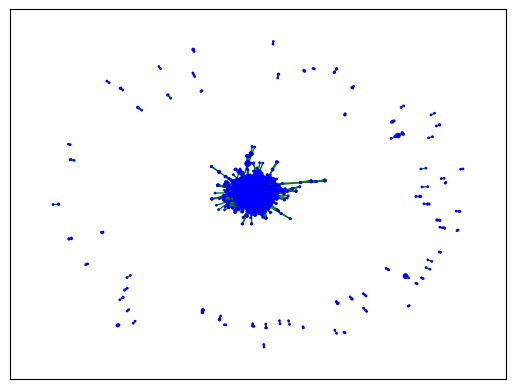

In [98]:
draw_social_graph(graph, fullcon, fullnam)

**7.1. Проверяем кластерность**

In [106]:
clusterization = nx.eigenvector_centrality(graph)

In [108]:
centers = sorted(clusterization.items(), key=lambda x: x[1])

In [110]:
for x in centers[:10]:
    print(x)

(('суббота', 'ORG'), 3.9254589363390465e-20)
(('мишин', 'PER'), 3.9254589363390465e-20)
(('сын', 'PER'), 3.9254589363390465e-20)
(('писание', 'PER'), 3.9254589363390465e-20)
(('свч', 'ORG'), 3.9254589363390465e-20)
(('растопить', 'PER'), 3.9254589363390465e-20)
(('базя', 'PER'), 3.9254589363390465e-20)
(('баз', 'PER'), 3.9254589363390465e-20)
(('фабрика', 'ORG'), 3.9254589363390465e-20)
(('скрыло', 'PER'), 3.9254589363390465e-20)


**Вот, значит, с чем чаще всего взаимодействуют люди! :)**